In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [69]:
from cpymad.madx import Madx

import pysixtracklib as pyst
from pysixtracklib import stcommon as st

import ctypes

In [3]:
from scipy.constants import e, m_p, c

In [85]:
import pycuda.autoinit
from pycuda import gpuarray as gp

In [84]:
def idivup(a, b):
    ''' Compute int(a)//int(b) and round up to next integer if a%b != 0 '''
    a = np.int32(a)
    b = np.int32(b)
    z = (a // b + 1) if (a % b != 0) else (a // b)
    return int(z)

In [4]:
p0c = 6 * 1e9 # in eV
Etot = np.sqrt(p0c**2 + (m_p/e)**2 * c**4) * 1e-9 # in GeV

In [5]:
madx = Madx()
madx.options.echo = False


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.04.02  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2018.10.03               +
  + Execution date: 2019.05.20 17:56:27      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [6]:
madx.call(file="sis18_thin.seq")

In [7]:
madx.command.beam(particle='proton', energy=str(Etot)) # energy in GeV

True

In [8]:
madx.use(sequence="FODO")

In [9]:
twiss = madx.twiss();

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
       216.7081404                 -0      0.03859155171         5.09042308 

                q1                dq1            betxmax              dxmax 
       4.577598169       -4.337325087        15.52637808        2.457595991 

             dxrms             xcomax             xcorms                 q2 
       1.851915623                  0                  0        2.718441832 

               dq2            betymax              dymax              dyrms 
       -6.04407507        33.60548239                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

In [10]:
# madx.input('''
# USE, sequence=FODO;
# ! select, flag=seqedit, class=instrument;
# ! select, flag=seqedit, class=marker;
# SEQEDIT, sequence=FODO;
#     ! remove, element=selected;
#     remove, element=FODO$START;
#     remove, element=FODO$END;
#     flatten;
# ENDEDIT;
# USE, sequence=FODO;
# ''')

In [11]:
circumference = twiss.summary.length
assert circumference == twiss['s'][-1]

In [12]:
Qx = twiss.summary['q1']

# Inject SC markers to compute TWISS functions in these places

In [13]:
n_scnodes = 12*20
l_target = circumference / n_scnodes
l_target

0.9029505849999999

In [23]:
madx.input("""
myvalue(xx,yy,zz): macro = {myval = table(xx,yy,zz);};

sc_placeholder : Marker; 
option, -info;
l_target = """ + str(l_target) + """;
l_fuzz = l_target/2.;
rows = table(twiss,tablelength);
seqedit, sequence=FODO;
while(i<rows){
    i = i+1;
    exec, myvalue(twiss,l,$i);
    length = myval;
    if(length > l_target + l_fuzz){
        ! value, length;
        l_remaining = length;
        exec, myvalue(twiss,s,$i);
        s = myval - length;
        while (l_remaining > l_target){
            s = s + l_target;
            value, s;
            install, element=sc_placeholder, at=s;
            l_remaining = l_remaining - l_target;
        }
    }
}
flatten;
option, info;
endedit;
""")

s                  =        7.607533918 ;
s                  =        8.510484503 ;
s                  =        9.413435088 ;
s                  =        10.31638567 ;
s                  =        11.21933626 ;
s                  =        12.12228684 ;
s                  =        13.02523743 ;
s                  =        25.66654562 ;
s                  =         26.5694962 ;
s                  =        27.47244679 ;
s                  =        28.37539737 ;
s                  =        29.27834796 ;
s                  =        30.18129854 ;
s                  =        31.08424913 ;
s                  =        43.72555732 ;
s                  =         44.6285079 ;
s                  =        45.53145849 ;
s                  =        46.43440907 ;
s                  =        47.33735966 ;
s                  =        48.24031024 ;
s                  =        49.14326083 ;
s                  =        61.78456902 ;
s                  =         62.6875196 ;
s                  =        63.590

True

In [24]:
madx.use(sequence='FODO')

In [25]:
twiss = madx.twiss();

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
       216.7081404                 -0      0.03859155171         5.09042308 

                q1                dq1            betxmax              dxmax 
       4.577598169       -4.337325087        15.52637808        2.457595991 

             dxrms             xcomax             xcorms                 q2 
       1.860519781                  0                  0        2.718441832 

               dq2            betymax              dymax              dyrms 
       -6.04407507        33.60548239                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

In [26]:
madx.sequence.FODO.element_names()

['fodo$start',
 'rb..1',
 'rb..2',
 'rb..3',
 'rb..4',
 'rb',
 'rb..5',
 'rb..6',
 'rb..7',
 'rb..8',
 'rb..1[2]',
 'rb..2[2]',
 'rb..3[2]',
 'rb..4[2]',
 'rb[2]',
 'rb..5[2]',
 'rb..6[2]',
 'rb..7[2]',
 'rb..8[2]',
 'sc_placeholder',
 'sc_placeholder[2]',
 'sc_placeholder[3]',
 'sc_placeholder[4]',
 'sc_placeholder[5]',
 'sc_placeholder[6]',
 'sc_placeholder[7]',
 'qs1f..1',
 'qs1f..2',
 'qs1f..3',
 'qs1f..4',
 'qs1f',
 'qs1f..5',
 'qs1f..6',
 'qs1f..7',
 'qs1f..8',
 'qs2d..1',
 'qs2d..2',
 'qs2d..3',
 'qs2d..4',
 'qs2d',
 'qs2d..5',
 'qs2d..6',
 'qs2d..7',
 'qs2d..8',
 'qs3t..1',
 'qs3t..2',
 'qs3t..3',
 'qs3t..4',
 'qs3t',
 'qs3t..5',
 'qs3t..6',
 'qs3t..7',
 'qs3t..8',
 'rb..1[3]',
 'rb..2[3]',
 'rb..3[3]',
 'rb..4[3]',
 'rb[3]',
 'rb..5[3]',
 'rb..6[3]',
 'rb..7[3]',
 'rb..8[3]',
 'rb..1[4]',
 'rb..2[4]',
 'rb..3[4]',
 'rb..4[4]',
 'rb[4]',
 'rb..5[4]',
 'rb..6[4]',
 'rb..7[4]',
 'rb..8[4]',
 'sc_placeholder[8]',
 'sc_placeholder[9]',
 'sc_placeholder[10]',
 'sc_placeholder[11]',


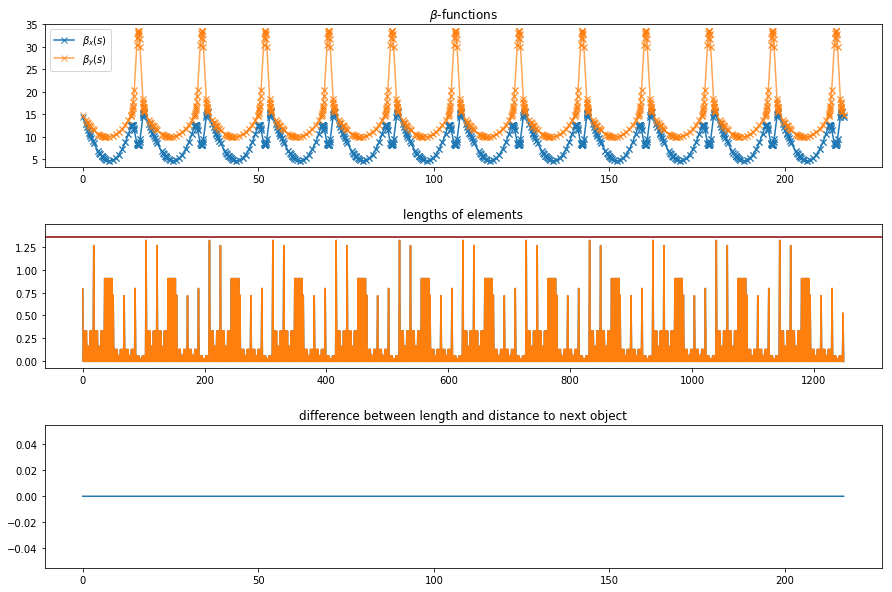

In [27]:
fig, ax = plt.subplots(3, 1, figsize=(15,10))

plt.sca(ax[0])
plt.title(r'$\beta$-functions')
plt.plot(twiss['s'], twiss['betx'], marker='x', label=r'$\beta_x(s)$')
plt.plot(twiss['s'], twiss['bety'], marker='x', label=r'$\beta_y(s)$', alpha=0.7)
plt.legend()

plt.sca(ax[1])
plt.title('lengths of elements')
plt.plot(np.diff(twiss['s']))
plt.plot(twiss['l'][1:])
plt.axhline(l_target*1.5, color='darkred')
plt.ylim(top=l_target*1.5*1.1)

plt.sca(ax[2])
plt.title('difference between length and distance to next object')
plt.plot(twiss['s'][:-1], np.diff(twiss['s']) - twiss['l'][1:])

plt.subplots_adjust(hspace=0.4)

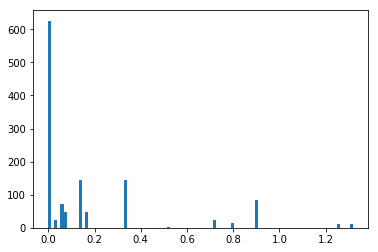

In [28]:
n, _, _ = plt.hist(twiss['l'], bins=100);
assert n[0] - 1 == np.sum(n[1:])

# Construct PySTL lattice on CPU

In [29]:
elements = pyst.Elements.from_mad(madx.sequence.FODO)

In [30]:
assert (
    len(elements.get_elements()) // 2 + 1 == 
    len(madx.sequence.FODO.elements)
), ( 
    "Did not generate the same number of PySixTrackLib "
    "lattice elements as there are in the MAD-X lattice! "
    "This will mess up the computation of SC node lengths..."
)

$\longrightarrow$ start with a 0-length drift (FODO\\$START marker) and end with a 0-length drift (FODO\\$END marker), otherwise have $(\text{number of multipoles/non-drifts}) + 1$ drifts

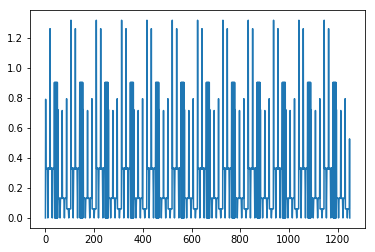

In [35]:
plt.plot(list(map(lambda e: e.length, elements.get_elements())))

In [49]:
idx_mad_sc = [i for i, name in enumerate(madx.sequence.FODO.element_names()) 
              if 'sc_placeholder' in name]
sc_optics = {
    'beta_x': twiss['betx'][idx_mad_sc],
    'beta_y': twiss['bety'][idx_mad_sc],
    'x': twiss['x'][idx_mad_sc],
    'y': twiss['y'][idx_mad_sc],
    's': twiss['s'][idx_mad_sc]
}

In [59]:
# PySTL contains both drifts and non-drifts in lattice as opposed to MAD-X:
idx_pyst_sc = map(lambda x: 2*x, idx_mad_sc)

In [57]:
idx_pyst_zerodrifts = [
    i for i, el in enumerate(elements.get_elements()) 
    if isinstance(el, pyst.Drift) and el.length == 0
]

In [58]:
# all MAD-X sc_placeholders correspond to a zero-length drift in PySTL
# (but there are more empty drifts than sc_placeholders)
assert set(idx_pyst_sc).issubset(set(idx_pyst_zerodrifts))

# Getting particle array pointers from PySTL on GPU

In [87]:
n_macroparticles = 1000

pyst_beam = pyst.Particles.from_ref(
    num_particles=n_macroparticles, p0c=p0c)

In [88]:
ctx = st.st_CudaContext_create()

In [89]:
# creating particles buffer itself
particles_arg = st.st_CudaArgument_new(ctx)
ptr_buffer = st.st_Buffer_new_mapped_on_cbuffer(pyst_beam._buffer)
assert st.st_CudaArgument_send_buffer(particles_arg, ptr_buffer) == 0, \
        "could not remap particles on GPU"

In [90]:
# creating particles with pointers to actual array contents in particles
particles_addr = st.st_ParticlesAddr()
sizeof_particles_addr = ctypes.c_uint64(ctypes.sizeof(particles_addr))
ptr_particles_addr = st.st_ParticlesAddr_preset(ctypes.byref(particles_addr))

particles_addr_arg = st.st_CudaArgument_new(ctx)
assert st.st_CudaArgument_send_memory(particles_addr_arg, ptr_particles_addr, sizeof_particles_addr)

In [91]:
# 
assert st.st_Particles_extract_addresses_cuda(
    st.st_CudaArgument_get_arg_buffer(particles_addr_arg),
    st.st_CudaArgument_get_arg_buffer(particles_arg)
) == 0

In [92]:
assert st.st_CudaArgument_receive_memory(particles_addr_arg, ptr_particles_addr, sizeof_particles_addr)

# Prepare interface to PyHEADTAIL

In [ ]:
gp_kwargs = dict(shape=n_macroparticles, dtype=np.float64)

x = gp.GPUArray(gpudata=particles_addr.x, **gp_kwargs)
xp = gp.GPUArray(gpudata=particles_addr.px, **gp_kwargs)
y = gp.GPUArray(gpudata=particles_addr.y, **gp_kwargs)
yp = gp.GPUArray(gpudata=particles_addr.py, **gp_kwargs)
z = gp.GPUArray(gpudata=particles_addr.zeta, **gp_kwargs)
dp = gp.GPUArray(gpudata=particles_addr.delta, **gp_kwargs)

In [ ]:
class TrackSixTrackLib(object): # to become PyHEADTAIL.general.elements.Element
    def __init__(self, elements, i_start, i_end):
        self.elements = elements
        self.i_start = ctypes.c_uint64(i_start)
        self.i_end = ctypes.c_uint64(i_end)
        n_elements = len(elements.get_elements())
        self.is_last_element = i_end == n_elements

    def track(self, beam):
        # pass arrays and convert units
        self.pyht_to_stlib(beam)
        # track in SixTrackLib
        assert st.st_Track_particles_line_cuda_on_grid(
            st.st_CudaArgument_get_arg_buffer(particles_arg),
            st.st_CudaArgument_get_arg_buffer(lattice_arg),
            self.i_start, self.i_end, ctypes.c_bool(self.is_last_element),
            # cuda grid / block definition:
            idivup(num_particles, 256), 256,
        )
        # pass arrays back (converting units back)
        self.stlib_to_pyht(beam)

    def pyht_to_stlib(self, beam):
        x[:] = beam.x
        px[:] = 1 * beam.xp
        y[:] = beam.y
        py[:] = 1 * beam.yp
        z[:] = beam.z
        delta[:] = beam.dp

    def stlib_to_pyht(self, beam):
        beam.x = x
        beam.xp = 1 * px
        beam.y = y
        beam.yp = 1 * py
        beam.z = z
        beam.dp = delta

# Move PySTL lattice to GPU

In [82]:
lattice = st.st_Buffer_new_mapped_on_cbuffer(elements.cbuffer)
lattice_arg = st.st_CudaArgument_new(ctx)
assert st.st_CudaArgument_send_buffer(lattice_arg, lattice) == 0, 'could not transfer lattice to GPU'

# Prepare PyHEADTAIL style one-turn map